In [13]:
import pandas as pd
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [4]:
distances = pd.read_csv("../DataAcquisition/shortest_distances.csv")

### Checking if the distances are normally distributed:

In [5]:
stats.normaltest(distances['distance_km']).pvalue

1.14823205293538e-230

### First Idea
1. Splitting the distances into **equal** length **bins** and seeing how many outages occured that have distances in that distance interval for example from (0,3), is the number of outages that had a distance of between 0 to 3 to the nearest station.
2. Now we **groupby** these intervals and aggregate by counting the number of outages that are in this interval. This gives us outages per distance
3. We can do a statistical test like a **T-test** to see if there is a significant different between the first half of these outages compared to the second half of these outages.

In [6]:
#this cuts the data into 3 equal width bins.
data = pd.Series([2,19,1,20, 13, 19, 24, 30])
bins = pd.cut(data, bins=3)
print(bins)

0     (0.971, 10.667]
1    (10.667, 20.333]
2     (0.971, 10.667]
3    (10.667, 20.333]
4    (10.667, 20.333]
5    (10.667, 20.333]
6      (20.333, 30.0]
7      (20.333, 30.0]
dtype: category
Categories (3, interval[float64, right]): [(0.971, 10.667] < (10.667, 20.333] < (20.333, 30.0]]


In [7]:
n = 10 #number of bins
distance_bins = pd.cut(distances['distance_km'], bins=n)
distances['distance_bin'] = distance_bins
outages_per_dist = distances.groupby(['distance_bin']).size()
outages_per_dist = pd.DataFrame(outages_per_dist)
outages_per_dist = outages_per_dist.rename(columns={0:"#of outages"})
outages_per_dist


C:\Users\dorsa\AppData\Local\Temp\ipykernel_19560\1079504366.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outages_per_dist = distances.groupby(['distance_bin']).size()


,#of outages
distance_bin,
"(-0.396, 45.623]",548
"(45.623, 91.186]",2
"(91.186, 136.749]",3
"(136.749, 182.312]",1
"(182.312, 227.875]",1
"(227.875, 273.439]",0
"(273.439, 319.002]",0
"(319.002, 364.565]",0
"(364.565, 410.128]",0


### Checking for correlations: **distance vs timeout**
Checking if there is any correlation between the distance of the outage to the station and the time it took for the outage to be resolved.

In [8]:
outages = pd.read_csv("../DataAcquisition/outages.csv")
outages['dateOn']
outages['dateOn'] = outages['dateOn'].apply(datetime.fromisoformat)
outages['dateOff'] = outages['dateOff'].apply(datetime.fromisoformat)
outages['timeOut'] = outages['dateOn'] - outages['dateOff']
outages['timeOut'] = outages['timeOut'].apply(lambda x: x.total_seconds()/60)
outages['timeOut']
#timeout is the total of minutes without power (we can change it into hours if its better)

0      3551.883333
1       354.066667
2       495.483333
3       516.883333
4       127.033333
          ...     
551     163.716667
552     124.633333
553      88.400000
554      52.133333
555      72.300000
Name: timeOut, Length: 556, dtype: float64

In [11]:
stats.normaltest(outages['timeOut']).pvalue

9.81623413911596e-164

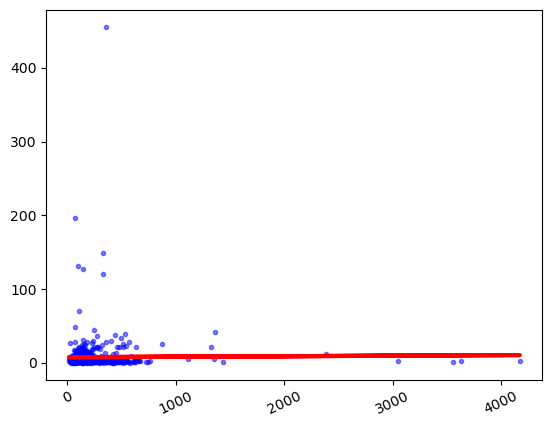

In [9]:
fit = stats.linregress(outages['timeOut'], distances['distance_km'])
plt.xticks(rotation = 25)
plt.plot(outages["timeOut"], distances["distance_km"], 'b.', alpha = 0.5)
plt.plot(outages["timeOut"], outages["timeOut"]*fit.slope + fit.intercept, 'r-', linewidth = 3)
plt.show()
#this plot doesnt look good because the distance csv that I created was not very good. 
#it would be nice to try it on our actual big dataset and the corresponding distances csv

In [10]:
outages["timeOut"].corr(distances["distance_km"])

0.009963038120639272

### Trying transformations:

In [14]:
outages["timeOut"].apply(np.sqrt).corr(distances["distance_km"].apply(np.sqrt))

0.031282251464092845

### Log transformation:


In [15]:
outages["timeOut"].apply(np.log).corr(distances["distance_km"].apply(np.log))

0.03851396642961312

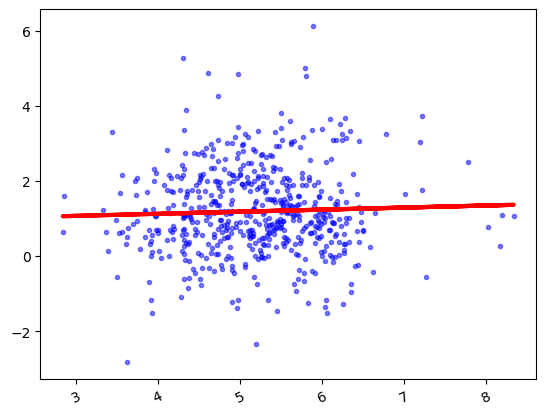

In [19]:
timeouts_transformed = outages["timeOut"].apply(np.log)
distance_transformed = distances["distance_km"].apply(np.log)
fit = stats.linregress(timeouts_transformed, distance_transformed)
plt.xticks(rotation = 25)
plt.plot(timeouts_transformed, distance_transformed, 'b.', alpha = 0.5)
plt.plot(timeouts_transformed, timeouts_transformed*fit.slope + fit.intercept, 'r-', linewidth = 3)
plt.show()

Using log makes better bins as well! 
but are the bins even meaningful?

In [16]:
n = 10 #number of bins
distance_bins = pd.cut(distances['distance_km'].apply(np.log), bins=n)
distances['distance_bin'] = distance_bins
outages_per_dist = distances.groupby(['distance_bin']).size()
outages_per_dist = pd.DataFrame(outages_per_dist)
outages_per_dist = outages_per_dist.rename(columns={0:"#of outages"})
outages_per_dist

C:\Users\dorsa\AppData\Local\Temp\ipykernel_19560\4030895775.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outages_per_dist = distances.groupby(['distance_bin']).size()


,#of outages
distance_bin,
"(-2.828, -1.925]",2
"(-1.925, -1.031]",13
"(-1.031, -0.137]",37
"(-0.137, 0.757]",159
"(0.757, 1.651]",168
"(1.651, 2.545]",107
"(2.545, 3.439]",56
"(3.439, 4.334]",8
"(4.334, 5.228]",4
